In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath
import dill as pickle
import sinter
import qc_utils.stats
import qc_utils.matplotlib_setup as mpl_setup
import multiprocess as mp

from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import RayModelType, GoogleNoiseParamsNoRandomRays
from ray_delay.ray_detector import RayDetectorSpec, RayImpactSimulator
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

In [2]:
mpl_setup.setup_default()

In [3]:
dx = 11
dz = 11
dm = 3

mpmath.mp.dps = 50

In [4]:
def get_qubit_rates(detector_fractions, syndrome_qubits):
    rates = {}
    for i, syndrome_qubit in enumerate(syndrome_qubits):
        rates[syndrome_qubit.idx] = detector_fractions[i]
    return rates

In [5]:
patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
baseline_detections = np.mean(patch.patch.count_detection_events(10**5)[0], axis=0)
syndrome_qubits = patch.patch.get_syndrome_qubits()
baseline_qubit_rates = get_qubit_rates(baseline_detections, syndrome_qubits)

In [6]:
sim = RayImpactSimulator(patch, 3, 0, only_full_windows=True)
float(sim.false_positive_rate(baseline_qubit_rates, 6*3, 6*3, 1e-10)) * 6*3 * 15

1.366889436840192e-05

In [7]:
generate_data = False

In [8]:
def get_detection_latency(radius, strength, window_offline_radius=0):
    noise_params = GoogleNoiseParamsNoRandomRays.improve(10)
    noise_params.cosmic_ray_params.model = RayModelType.DIRECT
    noise_params.cosmic_ray_params.max_strength = strength
    patch = NoiseModelPatch(MemoryPatch(dx, dz, dm), noise_params=noise_params)
    center_qubit = patch.patch.device[dx][dz].idx
    patch.force_cosmic_ray(center_qubit, radius)
    affected_qubits = patch.noise_model.active_cosmic_rays[0].affected_qubits

    sim = RayImpactSimulator(patch, int(np.ceil(radius/2))+1, window_offline_radius, only_full_windows=True)
    temporal_window_size = 6*dm
    detection_fpr = 1e-8

    ray_detector_rates = np.mean(patch.patch.count_detection_events(10**6)[0], axis=0)
    ray_qubit_rates = get_qubit_rates(ray_detector_rates, syndrome_qubits)

    num_cycles = sim.find_num_cycles_v2(baseline_qubit_rates, ray_qubit_rates, mpmath.mpf(1-1e-6), temporal_window_size, detection_fpr, affected_qubits)

    return num_cycles, detection_fpr

In [9]:
if generate_data:
    radii = np.linspace(2, 8, 12)
    strengths = (1-np.geomspace(0.001, 0.1, 10))[::-1]

    radii_strengths = [(radius, strength) for radius in radii for strength in strengths]

    with mp.Pool(6) as pool:
        cycle_counts_2d = pool.starmap(get_detection_latency, [(r, s, r) for r in radii for s in strengths])

    cycle_counts_2d = np.array(cycle_counts_2d)

    cycle_counts = cycle_counts_2d[:,0].reshape((len(radii), len(strengths)))

    pickle.dump(
        {
            'radii': radii,
            'strengths': strengths,
            'cycle_counts': cycle_counts,
        },
        open('data/detection_cycle_counts_direct.pkl', 'wb')
    )
else:
    data = pickle.load(open('data/detection_cycle_counts_direct.pkl', 'rb'))
    radii = data['radii']
    strengths = data['strengths']
    cycle_counts = data['cycle_counts']

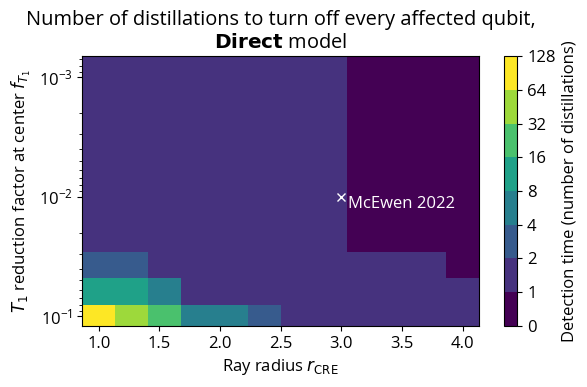

In [11]:
fig,ax = plt.subplots(figsize=(6.4, 3.5))

distillation_counts = cycle_counts / 6 / dm

x,y = np.meshgrid(radii/2, (1-strengths), indexing='ij')
vmin = 0
vmax = 2**np.ceil(np.log2(np.max(distillation_counts)))

norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
norm_boundaries = [0] + [2**i for i in range(0, np.log2(vmax).astype(int)+1)]
# norm_boundaries = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100]
norm = mpl.colors.BoundaryNorm(boundaries=norm_boundaries, ncolors=256)

plt.pcolormesh(x, y, distillation_counts, norm=norm)
cbar = plt.colorbar(label='Detection time (number of distillations)')
# round ticks to nearest 0.1
# cbar.set_ticks(cbar.get_ticks(), labels=[f'{t:0.1f}' for t in cbar.get_ticks()])

plt.plot([3], [0.01], 'x', color='w')
plt.annotate('McEwen 2022', (3, 0.01), textcoords='offset points', xytext=(5,-5), ha='left', va='center', color='w')

plt.yscale('log')
# plt.yticks([0.001, 0.01, 0.1], [0.999, 0.99, 0.9])
plt.ylabel(r'$T_1$ reduction factor at center $f_{T_1}$')
plt.xlabel(r'Ray radius $r_{\text{CRE}}$')
plt.gca().invert_yaxis()
# plt.title(r'Detecting cosmic rays, $\textbf{Direct}$ model')
plt.title('Number of distillations to turn off every affected qubit,\n' + r'$\bf{Direct}$ model')
plt.savefig('../figures/detection_direct.pdf', bbox_inches='tight')
plt.savefig('../figures/detection_direct.svg', bbox_inches='tight')

plt.show()

you could theoretically optimize for spacetime cost
by varying FPR and time to detect, but it is outside the scope of work

# Detecting rays in scrambling model

In [12]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath
import dill as pickle
import sinter
import qc_utils.stats
import qc_utils.matplotlib_setup as mpl_setup
import multiprocess as mp

from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import RayModelType
from ray_delay.ray_detector import RayDetectorSpec, RayImpactSimulator
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

In [13]:
mpl_setup.setup_default()

In [14]:
mpmath.mp.dps = 50

In [15]:
dx = 9
dz = 9
dm = 3

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm), seed=0)

ler_shots = 10**7
baseline_ler = patch.patch.count_logical_errors(ler_shots, max_errors=500)[0]
print(baseline_ler)

detection_shots = 10**5
baseline_detector_rates = np.mean(patch.patch.count_detection_events(detection_shots)[0], axis=0)
print(baseline_detector_rates.mean())

5.6e-06
0.0169825625


In [16]:
def get_qubit_rates(detector_fractions, syndrome_qubits):
    rates = {}
    for i, syndrome_qubit in enumerate(syndrome_qubits):
        rates[syndrome_qubit.idx] = detector_fractions[i]
    return rates

In [17]:
syndrome_qubits = patch.patch.get_syndrome_qubits()
baseline_qubit_rates = get_qubit_rates(baseline_detector_rates, syndrome_qubits)

In [18]:
def get_detection_latency(radius, strength, window_offline_radius=0, seed=None):
    # avg_detector_rates = None
    # for _ in range(100):
    patch = NoiseModelPatch(MemoryPatch(dx, dz, dm), seed=seed)
    patch.noise_model._noise_params.cosmic_ray_params.model = RayModelType.SCRAMBLING
    patch.noise_model._noise_params.cosmic_ray_params.max_strength = strength
    center_qubit = patch.patch.device[dx][dz].idx
    patch.force_cosmic_ray(center_qubit, radius)
    affected_qubits = patch.noise_model.active_cosmic_rays[0].affected_qubits

    ray_detector_rates = np.mean(patch.patch.count_detection_events(10**5)[0], axis=0)
    #     if avg_detector_rates is None:
    #         avg_detector_rates = ray_detector_rates
    #     else:
    #         avg_detector_rates += ray_detector_rates
    # avg_detector_rates /= 100
    
    ray_qubit_rates = get_qubit_rates(ray_detector_rates, syndrome_qubits)

    sim = RayImpactSimulator(patch, int(np.ceil(radius)), window_offline_radius, only_full_windows=True)
    # sim = RayImpactSimulator(patch, 2)
    temporal_window_size = 6*dm
    detection_fpr = 1e-8

    # TODO: optimize over detection_fpr and num_cycles
    # should be convex. detection_fpr gives different results for num_cycles,
    # and we want to minimize the overall spacetime cost
    num_cycles = sim.find_num_cycles_v2(baseline_qubit_rates, ray_qubit_rates, mpmath.mpf(1-1e-6), temporal_window_size, detection_fpr, affected_qubits)
    # while num_cycles > 2*temporal_window_size:
    #     detection_fpr *= 10
    #     num_cycles = sim.find_num_cycles_v2(baseline_qubit_rates, ray_qubit_rates, mpmath.mpf(1-1e-8), temporal_window_size, detection_fpr, affected_qubits)

    return num_cycles, detection_fpr

In [19]:
generate_data = False

In [20]:
if generate_data:
    radii_scrambling = np.linspace(2, 8, 1200)

    with mp.Pool(6) as pool:
        cycle_counts_scrambling = pool.starmap(get_detection_latency, [(r, 1.0, 1.5*r, i) for i,r in enumerate(radii_scrambling)])

    cycle_counts_scrambling = np.array(cycle_counts_scrambling)
    # cycle_counts_radius = np.array(cycle_counts_radius)

    pickle.dump(
        {
            'radii': radii_scrambling,
            'cycle_counts': cycle_counts_scrambling,
        },
        open('data/detection_cycle_counts_scrambling.pkl', 'wb')
    )
else:
    data = pickle.load(open('data/detection_cycle_counts_scrambling.pkl', 'rb'))
    radii_scrambling = data['radii']
    cycle_counts_scrambling = data['cycle_counts']

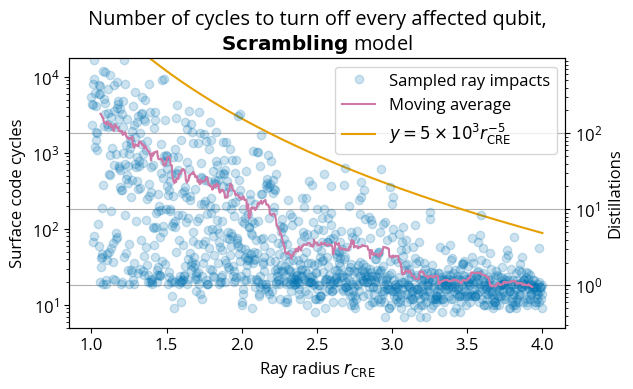

In [21]:
fig,ax = plt.subplots(figsize=(6.4, 3.5))

plt.plot(radii_scrambling/2, cycle_counts_scrambling[:,0], 'o', alpha=0.2, label='Sampled ray impacts')
avg, xs = qc_utils.stats.moving_average(cycle_counts_scrambling[:,0][np.isfinite(cycle_counts_scrambling[:,0])], 50, return_x=True)
plt.plot(radii_scrambling[xs]/2, avg, '-', label='Moving average')


plt.xlabel(r'Ray radius $r_{\text{CRE}}$')
plt.ylim(5)

ax = plt.gca()

ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim()[0]/6/dm, ax.get_ylim()[1]/6/dm)

ax1.plot(radii_scrambling/2, 5*10**3*(radii_scrambling/2)**(-5), '-', color='C3', label=r'$y=5 \times 10^3r_{\text{CRE}}^{-5}$')
# TODO: combine legends

ax.set_ylabel('Surface code cycles')
ax1.set_ylabel('Distillations')

ax.set_yscale('log')
ax1.set_yscale('log')
ax1.grid()

# show combined legend
lines, labels = ax.get_legend_handles_labels()
lines1, labels1 = ax1.get_legend_handles_labels()
ax.legend(lines + lines1, labels + labels1, loc='upper right')

# make grid lines appear behind data and legend
ax.set_zorder(1)
ax1.set_zorder(0)
ax.patch.set_visible(False)

plt.title('Number of cycles to turn off every affected qubit,\n' + r'$\bf{Scrambling}$ model')

plt.savefig('../figures/detection_scrambling.pdf', bbox_inches='tight')
plt.savefig('../figures/detection_scrambling.svg', bbox_inches='tight')
plt.show()

In [21]:
radii = np.linspace(2, 8, 1000)

def get_signal_chance_and_task(i):
    patch = NoiseModelPatch(MemoryPatch(dx, dz, dm), seed=0)
    patch.noise_model.rng = np.random.default_rng(i)
    patch.noise_model._noise_params.cosmic_ray_params.model = RayModelType.SCRAMBLING
    center_qubit = patch.patch.device[dx][dz].idx
    patch.force_cosmic_ray(center_qubit, radii[i])

    detector_rates = np.mean(patch.patch.count_detection_events(10**5)[0], axis=0)
    task = patch.patch.get_sinter_task(task_kwargs={'json_metadata':{'i':i, 'radius':radii[i]}})

    return detector_rates, task

with mp.Pool(6) as pool:
    combined_results = pool.map(get_signal_chance_and_task, range(len(radii)))

detector_rates = np.array([result[0] for result in combined_results])
tasks = [result[1] for result in combined_results]

In [22]:
results = sinter.collect(tasks=tasks, num_workers=6, decoders='pymatching', max_shots=10**6, max_errors=500)

In [23]:
lers = np.zeros(len(radii))
radii = np.zeros(len(radii))
for task_result in results:
    lers[task_result.json_metadata['i']] = task_result.errors / task_result.shots
    radii[task_result.json_metadata['i']] = task_result.json_metadata['radius']

In [24]:
detector_plot_rates = np.mean(detector_rates, axis=1)
detector_bounds = np.array([qc_utils.stats.fit_binomial(num_shots=detection_shots, num_hits=int(detection_shots*detector_rate), max_likelihood_factor=1000) for detector_rate in detector_rates.mean(axis=1)])
ler_bounds = np.array([qc_utils.stats.fit_binomial(num_shots=ler_shots, num_hits=int(ler_shots*ler), max_likelihood_factor=1000) for ler in lers])

baseline_detector_plot_rates = np.mean(baseline_detector_rates)
baseline_detection_bounds = qc_utils.stats.fit_binomial(num_shots=detection_shots, num_hits=int(baseline_detector_plot_rates*detection_shots), max_likelihood_factor=1000)
baseline_ler_bounds = qc_utils.stats.fit_binomial(num_shots=ler_shots, num_hits=int(ler_shots*baseline_ler), max_likelihood_factor=1000)

baseline_ler_bounds, baseline_detection_bounds

((5.758e-06, 1.2762e-05), (0.0155917, 0.0186372))

Text(0, 0.5, 'Logical error rate')

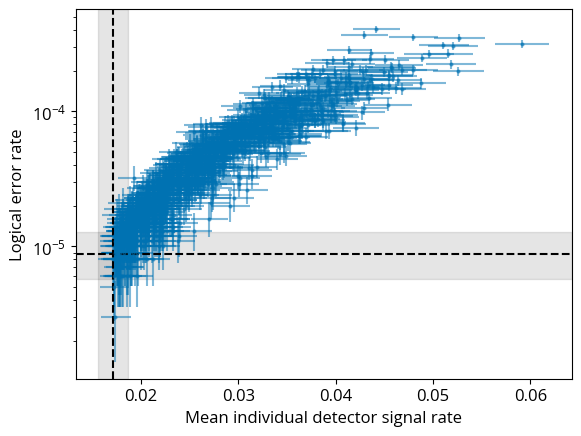

In [25]:
ler_errs = np.abs(lers[:,None][:,[0,0]] - ler_bounds)
detector_errs = np.abs(detector_plot_rates[:,None][:,[0,0]] - detector_bounds)

plt.errorbar(detector_plot_rates, lers, yerr=[ler_errs[:,0], ler_errs[:,1]], xerr=[detector_errs[:,0], detector_errs[:,1]], linestyle='None', marker='o', markersize=2, alpha=0.5)
plt.axvline(baseline_detector_rates.mean(), color='black', linestyle='--', label='Baseline')
plt.axvspan(*baseline_detection_bounds, color='black', alpha=0.1)
plt.axhline(baseline_ler, color='black', linestyle='--')
plt.axhspan(*baseline_ler_bounds, color='black', alpha=0.1)
plt.yscale('log')
plt.xlabel('Mean individual detector signal rate')
plt.ylabel('Logical error rate')

If recovery time is on the order of seconds or longer (i.e. if a full
recalibration is needed), the scrambling rays quickly become extremely
expensive. Potential instant-time recovery: have precalculated alternative
viable frequencies to operate qubit at, and switch to those. (from Klimov, TLSs
are relatively sparse in frequency space). This method could also be used in the
computational qubits of the surface code to reduce the overhead of the code
expansion or distributed approaches in that case.